In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re
import importlib

import h5py
from scipy.ndimage import zoom

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns #import automapRecon
import unrolling_fns

2024-12-16 14:20:05.550257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 14:20:07.088030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
R = 4 # acceleration factor
calib_size = 10

loss_fn = 'mse'
#loss_fn = 'perceptual'


In [4]:
# if R==2:
#     if loss_fn=='perceptual':
#         unroll_model_pth = 'trained_models/Unrolling/Unroll_perceptual_R2.pth'
#         model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240614_percepmse/checkpoint/model.keras' #evenly weight perceptual and mse loss
#         model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_imag_noise_bkgd_202400614_percepmse/checkpoint/model.keras'
#     elif loss_fn == 'mse':
#         unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
#         model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
#         model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    
# elif R==4:
#     if loss_fn == 'perceptual':
#         unroll_model_pth = 'trained_models/Unrolling/Unroll_perceptual_R4.pth'
#     elif loss_fn == 'mse':
#         unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
#     #AUTOMAP model
#     model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
#     model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'


In [5]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'


## Importing Phantom Data

In [6]:
file_phantom_FS = 'data/volunteer_20240711/20240711_run4_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'
file_phantom_R2 = 'data/volunteer_20240711/20240711_run5_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R2_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'
file_phantom_R4 = 'data/volunteer_20240711/20240711_run6_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R4_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'

file_brain_FS = 'data/volunteer_20240711/20240711_run8_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
file_brain_R2 = 'data/volunteer_20240711/20240711_run9_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R2_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
file_brain_R4 = 'data/volunteer_20240711/20240711_run10_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R4_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'

In [7]:
def ksp_load(filename):
    data = loadmat(filename)
    ksp_shp = data['i_kspace'].shape

    if len(ksp_shp) > 3:
        ksp = np.moveaxis(data['i_kspace'],3,0)
    else:
        ksp = np.reshape(data['i_kspace'],(1,ksp_shp[0],ksp_shp[1],ksp_shp[2]))

    ksp = ksp[1,:,:,:]
    ksp = ksp[np.newaxis,:]

    return ksp

In [8]:
def recon_prospective_us( ksp, R, recon_method = 'ifft', lamda_opt=0.001, iter_opt = 30):
    #scaling data

    img_rss = np.sum(np.abs(sp.ifft(ksp, axes=(-1, -2, -3)))**2, axis=0)**0.5
    volumeZFrss = img_rss
    
    # scaling all numbers to sensible values from the beginning
    scale_factor = np.percentile(abs(volumeZFrss),95) 
    kspZFscaled = ksp/scale_factor
    
    yshift = -2
    kspZFscaled = np.roll(kspZFscaled,(0,yshift,0),axis=(1,2,3))
    
    
    
    if kspZFscaled.shape[0] == 1:
        mps = np.ones(kspZFscaled.shape,dtype=complex)
    else:
        mps = mr.app.EspiritCalib(kspZFscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
    #mps = np.ones(kspZFscaled.shape)
    img_fs = sp.ifft(kspZFscaled, axes=(-1, -2, -3))
    volumeZFscaled = coil_combine(img_fs,mps)

    #if R==1 or recon_method == 'zerofill':
        
    #else:
    mask = (np.abs(kspZFscaled[0,:,32,:]) > 0 )

    kspInput = kspZFscaled

    match recon_method:
        case 'ifft':
            return volumeZFscaled, scale_factor
        case 'cs':
            volcsrecon = ulfl1recon(kspInput,mask,lamda_opt,iter_opt,mps)
            return volcsrecon, scale_factor
        case 'automap':
            if R==2:
              model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
              model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
            elif R==4:
              model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
              model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
            volamaprecon, volamaprecon_mc = automap_fns.automapRecon(kspInput,mps,model_real_dir,model_imag_dir)
            volamaprecon = volamaprecon
            return volamaprecon, scale_factor
        case 'unrolled':
            if R==2:
                unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
            elif R==4:
                unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
            volunrollrecon = unrolling_fns.unrollingRecon(kspInput,mask,unroll_model_pth)
            return volunrollrecon, scale_factor    
    

In [9]:
ksp = ksp_load(file_phantom_FS)
R = 1
phantom_ifft_FS, scale_factor = recon_prospective_us( ksp, R, recon_method='ifft')

In [10]:
ksp = ksp_load(file_phantom_R2)
R = 2

phantom_zf_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='ifft')
phantom_cs_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='cs', lamda_opt=0.001, iter_opt = 30 )
phantom_amap_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='automap' )
phantom_unroll_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='unrolled' )

2024-12-16 14:20:12.043549: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-16 14:20:12.043619: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2024-12-16 14:20:12.043628: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2024-12-16 14:20:12.043721: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-12-16 14:20:12.043747: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-12-16 14:20:12.043755: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14


(1, 75, 64, 25)


In [11]:
ksp = ksp_load(file_phantom_R4)
R = 4

phantom_zf_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='ifft',)
phantom_cs_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='cs', lamda_opt=0.001, iter_opt = 30 )
phantom_amap_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='automap' )
phantom_unroll_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='unrolled' )

(1, 75, 64, 25)


In [12]:
slc=16

GT = phantom_ifft_FS
vol1_R2 = phantom_zf_R2
vol2_R2 = phantom_cs_R2
vol3_R2 = phantom_amap_R2
vol4_R2 = phantom_unroll_R2
vol1_R4 = phantom_zf_R4
vol2_R4 = phantom_cs_R4
vol3_R4 = phantom_amap_R4
vol4_R4 = phantom_unroll_R4

reftitle = '(a) Fully-Sampled'
vol1title = 'Zero-filled'
vol2title = 'Comp. Sensing'
vol3title = 'AUTOMAP'
vol4title = 'Unrolled AI'

In [13]:
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(GT),0.17))

#volumeGTscaledmasked = np.copy(volumeGTscaled)
GT[mask_metrics]=0
vol1_R2[mask_metrics]=0
vol2_R2[mask_metrics]=0
vol3_R2[mask_metrics]=0
vol4_R2[mask_metrics]=0
vol1_R4[mask_metrics]=0
vol2_R4[mask_metrics]=0
vol3_R4[mask_metrics]=0
vol4_R4[mask_metrics]=0

/home/david/repos/Low_Field_MRI_Recon/metrics.py:38: RuntimeWarning: invalid value encountered in divide
  im1_mag_uint8 = (I_true * 255 / np.max(I_true)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:38: RuntimeWarning: invalid value encountered in cast
  im1_mag_uint8 = (I_true * 255 / np.max(I_true)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in divide
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in cast
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')


(0.0, 1.0, 0.0, 1.0)

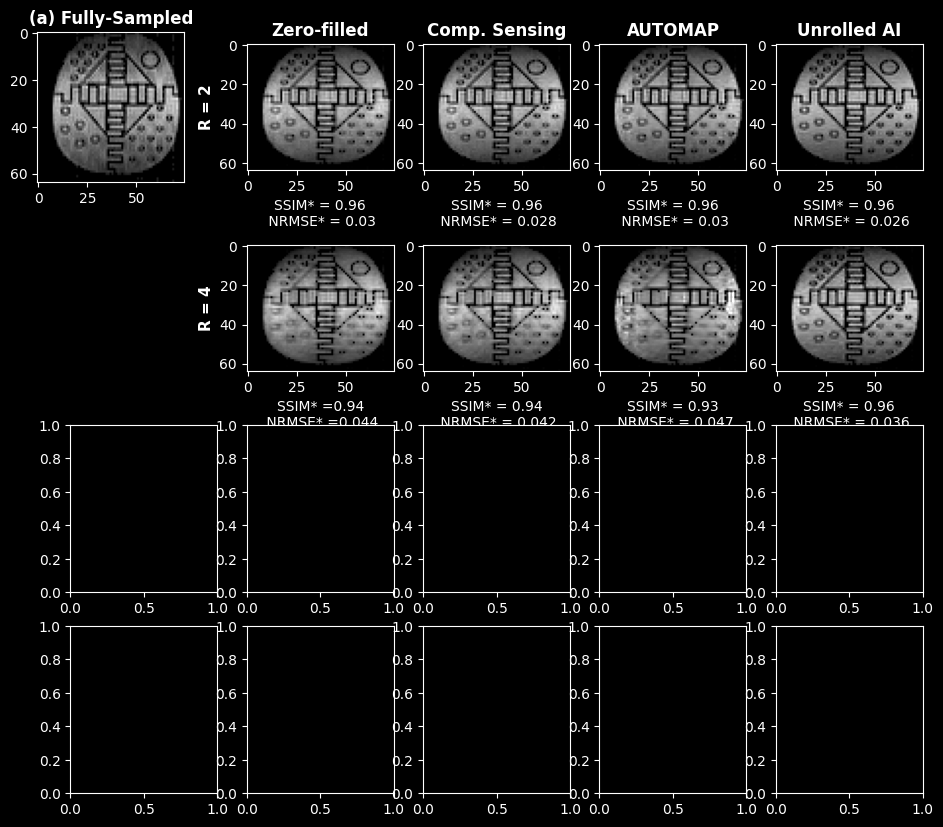

In [14]:
asp_ratio = (GT.shape[1]*3.5)/(GT.shape[0]*2.5)

plt.style.use('dark_background')


fig, axs = plt.subplots(4, 5,figsize = (11,10))

max_GT = np.amax(np.abs(GT[:,:,slc]))

im = axs[0, 0].imshow(np.abs(GT[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 0].set_title(reftitle,fontweight='bold')
axs[0, 0].set_aspect(asp_ratio)
l, b, w, h = axs[0,0].get_position().bounds
axs[0, 0].set_position([l-0.03,b,w,h])
im.set_clim(0, (1.05*max_GT))


im = axs[0, 1].imshow(np.abs(vol1_R2[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT)
axs[0, 1].set_title(vol1title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[0, 1].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol1_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol1_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

axs[0, 1].set_ylabel('R = 2',fontsize=11, fontweight='bold')

im = axs[1, 1].imshow(np.abs(vol1_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[1, 1].set_xlabel('SSIM* ='+str(round(ssim(np.abs(vol1_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* ='+str(round(nrmse(np.abs(vol1_R4[:,:,:]),np.abs(GT[:,:,:])),3)))
axs[1, 1].set_ylabel('R = 4',fontsize=11, fontweight='bold')


im = axs[0, 2].imshow(np.abs(vol2_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 2].set_title(vol2title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[0, 2].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol2_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol2_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[1, 2].imshow(np.abs(vol2_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[1, 2].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol2_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol2_R4[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[0, 3].imshow(np.abs(vol3_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 3].set_title(vol3title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[0, 3].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol3_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol3_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[1, 3].imshow(np.abs(vol3_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[1, 3].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol3_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol3_R4[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[0, 4].imshow(np.abs(vol4_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 4].set_title(vol4title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[0, 4].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol4_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol4_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[1, 4].imshow(np.abs(vol4_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[1, 4].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol4_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol4_R4[:,:,:]),np.abs(GT[:,:,:])),3)))

axs[1, 0].axis('off')

In [15]:
ksp = ksp_load(file_brain_FS)
R = 1
brain_ifft_FS, scale_factor = recon_prospective_us( ksp, R, recon_method='ifft')

In [16]:
ksp = ksp_load(file_brain_R2)
R = 2

brain_zf_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='ifft')
brain_cs_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='cs', lamda_opt=0.001, iter_opt = 30 )
brain_amap_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='automap' )
brain_unroll_R2, scale_factor = recon_prospective_us( ksp, R, recon_method='unrolled' )

(1, 75, 64, 25)


In [17]:
ksp = ksp_load(file_brain_R4)
R = 4

brain_zf_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='ifft',)
brain_cs_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='cs', lamda_opt=0.001, iter_opt = 30 )
brain_amap_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='automap' )
brain_unroll_R4, scale_factor = recon_prospective_us( ksp, R, recon_method='unrolled' )

(1, 75, 64, 25)


In [18]:
slc=17

GT = brain_ifft_FS
vol1_R2 = brain_zf_R2
vol2_R2 = brain_cs_R2
vol3_R2 = brain_amap_R2
vol4_R2 = brain_unroll_R2
vol1_R4 = brain_zf_R4
vol2_R4 = brain_cs_R4
vol3_R4 = brain_amap_R4
vol4_R4 = brain_unroll_R4

reftitle = '(b) Fully-Sampled'
vol1title = 'Zero-filled'
vol2title = 'Comp. Sensing'
vol3title = 'AUTOMAP'
vol4title = 'Unrolled AI'

In [19]:
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(GT),0.15))

#volumeGTscaledmasked = np.copy(volumeGTscaled)
GT[mask_metrics]=0
vol1_R2[mask_metrics]=0
vol2_R2[mask_metrics]=0
vol3_R2[mask_metrics]=0
vol4_R2[mask_metrics]=0
vol1_R4[mask_metrics]=0
vol2_R4[mask_metrics]=0
vol3_R4[mask_metrics]=0
vol4_R4[mask_metrics]=0

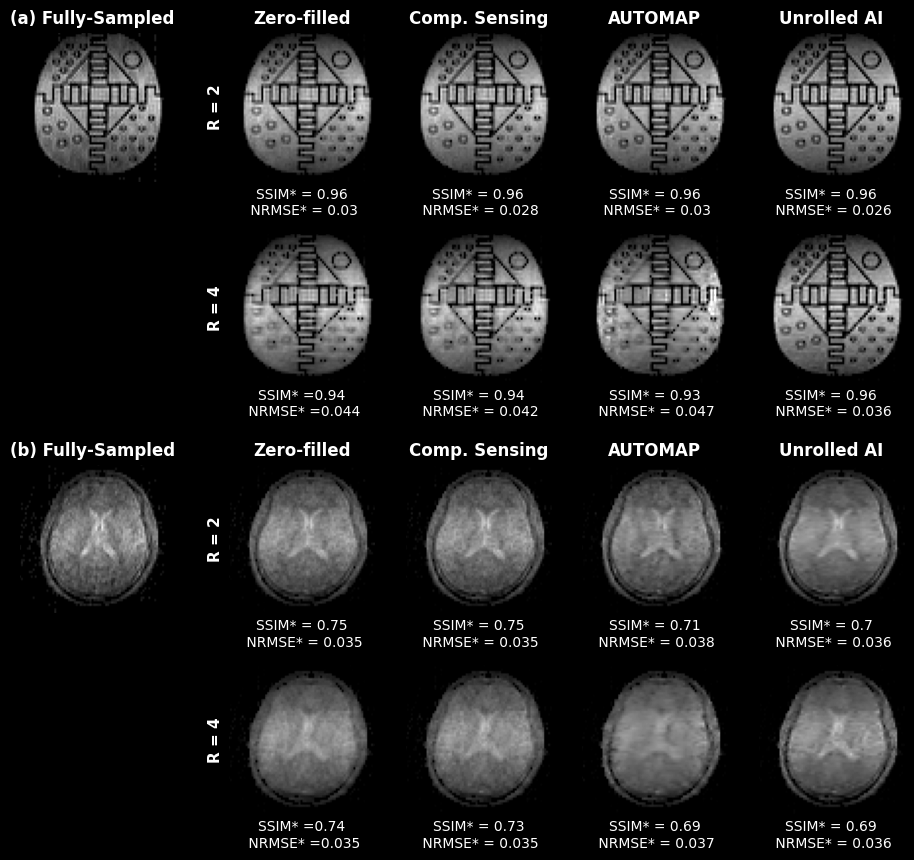

In [20]:
max_GT = np.amax(np.abs(GT[:,:,slc]))

im = axs[2, 0].imshow(np.abs(GT[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[2, 0].set_title(reftitle,fontweight='bold')
axs[2, 0].set_aspect(asp_ratio)
l, b, w, h = axs[2,0].get_position().bounds
axs[2, 0].set_position([l-0.03,b,w,h])
im.set_clim(0, (1.05*max_GT))

im = axs[2, 1].imshow(np.abs(vol1_R2[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT)
axs[2, 1].set_title(vol1title,fontweight='bold')
#axs[2, 1].set_xticks([])
#axs[2, 1].set_yticks([])
#axs[2, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[2, 1].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol1_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol1_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

axs[2, 1].set_ylabel('R = 2',fontsize=11, fontweight='bold')

im = axs[3, 1].imshow(np.abs(vol1_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[3, 1].set_xlabel('SSIM* ='+str(round(ssim(np.abs(vol1_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* ='+str(round(nrmse(np.abs(vol1_R4[:,:,:]),np.abs(GT[:,:,:])),3)))
axs[3, 1].set_ylabel('R = 4',fontsize=11, fontweight='bold')


im = axs[2, 2].imshow(np.abs(vol2_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[2, 2].set_title(vol2title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[2, 2].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol2_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol2_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[3, 2].imshow(np.abs(vol2_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[3, 2].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol2_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol2_R4[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[2, 3].imshow(np.abs(vol3_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[2, 3].set_title(vol3title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[2, 3].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol3_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol3_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[3, 3].imshow(np.abs(vol3_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[3, 3].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol3_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol3_R4[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[2, 4].imshow(np.abs(vol4_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[2, 4].set_title(vol4title,fontweight='bold')
im.set_clim(0, (1.05*max_GT))
axs[2, 4].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol4_R2[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol4_R2[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[3, 4].imshow(np.abs(vol4_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
im.set_clim(0, (1.05*max_GT))
axs[3, 4].set_xlabel('SSIM* = '+str(round(ssim(np.abs(vol4_R4[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE* = '+str(round(nrmse(np.abs(vol4_R4[:,:,:]),np.abs(GT[:,:,:])),3)))


axs[3, 0].axis('off')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(asp_ratio)
    ax.tick_params(color='k')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')

for j in range(2,4):
    for k in range(5):
        l, b, w, h = axs[j,k].get_position().bounds
        axs[j,k].set_position([l,b-0.03,w,h])

fig

